# NoteBook Model, Prédiction Bankrupt

Sommaire:

* [Import des Librairie et dataset](#Import-des-Librairie-et-dataset)
* [Preprocessing](#Preprocessing)
    * [Features selection](#Features-selection)
* [Sélection du modèle](#Selection-du-modèle)
    * [KNN Classifier](#KNN-Classifier)
    * [Gradient Boosting](#Gradient-Boosting)
    * [Decision Tree](#Decision-Tree)
    * [MLP](#Multi-Layer-Perceptron)
    * [Random Forest](#Random-Forest)
    * [Bagging + Random Forest](#Bagging-+-Random-Forest)
    * [AdaBoost + Random Forest](#AdaBoost-+-Random-Forest)
    * [Stacking + Random-Forest,-MLP,-LR](#Stacking-+-Random-Forest,-MLP,-LR)
* [Sélection du Model et Evaluation](#Sélection-du-Model-et-Evaluation)
    * [roc Curve](#Roc-Curve)
    * [Learning Curve](#Learning-Curve)
* [Pickle et nouvelle prédiction](#Pickle-et-nouvelle-prédiction)

# Import des Librairie et dataset

In [2]:
import numpy as np
import pandas as pd

# pd.set_option('max_columns', None)
import pickle
from imblearn.over_sampling import SMOTE
from sklearn.preprocessing import StandardScaler,RobustScaler,MinMaxScaler
from sklearn.linear_model import (SGDClassifier ,LogisticRegression)
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import (RandomForestClassifier, BaggingClassifier, 
                                GradientBoostingClassifier, AdaBoostClassifier, StackingClassifier)
from sklearn.metrics import (classification_report, confusion_matrix, 
                            f1_score,accuracy_score, precision_score, 
                             recall_score, roc_auc_score) 
from sklearn.model_selection import (train_test_split, StratifiedKFold, 
                                     RandomizedSearchCV,GridSearchCV,
                                     learning_curve,StratifiedShuffleSplit)
from sklearn.metrics import roc_auc_score, plot_roc_curve, roc_curve
from imblearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer

In [3]:
df = pd.read_csv('bankrupt.csv')

In [4]:
df.shape

(6819, 96)

# Preprocessing

## Features selection

In [7]:
df_corr = df.corr()['Bankrupt?'] 
golden_features_list = df.columns[abs(df_corr) > 0.15]
df_model = df[golden_features_list]

In [8]:
df_model.shape

(6819, 22)

Notre choisirons un dataset plus complet pour le modèle du mlp:

In [9]:
df_corr = df.corr()['Bankrupt?'] # 
golden_features_list = df.columns[abs(df_corr) > 0.05]
df_mlp = df[golden_features_list]

In [10]:
df_mlp.shape

(6819, 50)

# Selection du modèle

In [30]:
y = df_model['Bankrupt?']
X = df_model.drop('Bankrupt?', axis=1)

Décommenter et utiliser la cellule du bas pour le mlp:

In [14]:
# y = df_mlp['Bankrupt?']
# X = df_mlp.drop('Bankrupt?', axis=1)

Split des données avec le stratifiedKfold:

In [62]:
sf = StratifiedKFold(n_splits=5, shuffle=True, random_state=1)
#The folds are made by preserving the percentage of samples for each class.
for train_index, test_index in sf.split(X,y):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]

In [13]:
def model_training (model,parameter,df):

    # Create first pipe
    scaler = Pipeline([
        ('robustscaler', RobustScaler())])

    preprocessor = ColumnTransformer([
        ('scaler', scaler, df.drop('Bankrupt?', axis=1).columns)
        ],
        remainder='passthrough')

    pipe = Pipeline([
        ('preprocessing', preprocessor),
        ('smote', SMOTE(sampling_strategy='minority', random_state=10)),
        ('model', model)])

    #from sklearn.model_selection import RepeatedStratifiedKFold

    #cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=3, random_state=1)
    
    parameter = parameter
    #clf =RandomizedSearchCV(pipe,parameter,n_iter=4,cv=5,verbose=1)
    # gridsearchCV:
    clf =GridSearchCV(pipe,parameter,cv=5,verbose=1)
    clf.fit(X_train,y_train)
    best = clf.best_score_
    print(best)
    print(clf.best_params_)

    y_pred = clf.predict(X_test)
    print(classification_report(y_test, y_pred))
    print(confusion_matrix(y_test, y_pred))

## KNN Classifier

In [15]:
model_training(KNeighborsClassifier(),{'model__n_neighbors':[2,4,6,8,10,12],'model__weights':['uniform','distance']},df_model)

Fitting 5 folds for each of 12 candidates, totalling 60 fits
0.919178056895747
{'model__n_neighbors': 2, 'model__weights': 'uniform'}
              precision    recall  f1-score   support

           0       0.98      0.95      0.97      1319
           1       0.21      0.36      0.26        44

    accuracy                           0.93      1363
   macro avg       0.59      0.66      0.61      1363
weighted avg       0.95      0.93      0.94      1363

[[1257   62]
 [  28   16]]


## Gradient Boosting

In [16]:
model_training(GradientBoostingClassifier(),{'model__n_estimators':[100,110,120,150],'model__learning_rate':[0.1,0.5,1]},df_model)

Fitting 5 folds for each of 12 candidates, totalling 60 fits
0.9081819952122426
{'model__learning_rate': 0.5, 'model__n_estimators': 150}
              precision    recall  f1-score   support

           0       0.99      0.94      0.96      1319
           1       0.25      0.66      0.37        44

    accuracy                           0.93      1363
   macro avg       0.62      0.80      0.66      1363
weighted avg       0.96      0.93      0.94      1363

[[1234   85]
 [  15   29]]


## Decision Tree

In [17]:
model_training(DecisionTreeClassifier(),{'model__splitter':['best','random'],"model__max_depth": [3, 5, 10, None]},df_model)

Fitting 5 folds for each of 8 candidates, totalling 40 fits
0.9048836131787553
{'model__max_depth': None, 'model__splitter': 'best'}
              precision    recall  f1-score   support

           0       0.98      0.92      0.95      1319
           1       0.18      0.55      0.27        44

    accuracy                           0.90      1363
   macro avg       0.58      0.73      0.61      1363
weighted avg       0.96      0.90      0.93      1363

[[1207  112]
 [  20   24]]


## Multi Layer Perceptron

In [18]:
model_training(MLPClassifier(),{'model__max_iter':[300,400,500],'model__learning_rate':['adaptive'],'model__learning_rate_init':[0.1,0.5,1]},df_mlp)

Fitting 5 folds for each of 1 candidates, totalling 5 fits
0.7084151717515603
{'model__learning_rate': 'adaptive', 'model__learning_rate_init': 0.1, 'model__max_iter': 400}
              precision    recall  f1-score   support

           0       0.99      0.73      0.84      1319
           1       0.09      0.84      0.17        44

    accuracy                           0.73      1363
   macro avg       0.54      0.78      0.50      1363
weighted avg       0.96      0.73      0.82      1363

[[958 361]
 [  7  37]]


O.23 / 0.66

## Random Forest

In [18]:
model_training(RandomForestClassifier(),{'model__n_estimators':[150,200,250],'model__class_weight':['balanced_subsample'],'model__max_depth':[1,5,10]},df_model)

Fitting 5 folds for each of 9 candidates, totalling 45 fits
0.9061651608397712
{'model__class_weight': 'balanced_subsample', 'model__max_depth': 10, 'model__n_estimators': 250}
              precision    recall  f1-score   support

           0       0.99      0.93      0.96      1319
           1       0.29      0.84      0.44        44

    accuracy                           0.93      1363
   macro avg       0.64      0.89      0.70      1363
weighted avg       0.97      0.93      0.95      1363

[[1230   89]
 [   7   37]]


## Bagging + Random Forest

This code is too long to calculate 

In [6]:
# model_training(BaggingClassifier(),{'model__base_estimator':[RandomForestClassifier(class_weight='balanced_subsample')],'model__n_estimators':[100,110,120]},df_model)


Fitting 5 folds for each of 1 candidates, totalling 5 fits
0.9232087039144785
{'model__base_estimator': RandomForestClassifier(class_weight='balanced_subsample'), 'model__n_estimators': 10}
              precision    recall  f1-score   support

           0       0.99      0.95      0.97      1319
           1       0.35      0.77      0.48        44

    accuracy                           0.95      1363
   macro avg       0.67      0.86      0.73      1363
weighted avg       0.97      0.95      0.96      1363

[[1255   64]
 [  10   34]]


## AdaBoost + Random Forest

In [22]:
model_training(AdaBoostClassifier(),{'model__base_estimator':[RandomForestClassifier(n_estimators=250,max_depth=10,class_weight='balanced_subsample')],'model__n_estimators':[100,150]},df_model)

Fitting 5 folds for each of 2 candidates, totalling 10 fits
0.9191757066642493
{'model__base_estimator': RandomForestClassifier(class_weight='balanced_subsample', max_depth=10,
                       n_estimators=250), 'model__n_estimators': 100}
              precision    recall  f1-score   support

           0       0.99      0.95      0.97      1319
           1       0.35      0.80      0.49        44

    accuracy                           0.95      1363
   macro avg       0.67      0.87      0.73      1363
weighted avg       0.97      0.95      0.96      1363

[[1254   65]
 [   9   35]]


## Stacking + Random Forest, MLP, LR

In [23]:
estimators = [('rfc', RandomForestClassifier(n_estimators=250,max_depth=10,class_weight='balanced_subsample')),]

In [24]:
model_training(StackingClassifier(estimators=estimators),{'model__final_estimator':[LogisticRegression(class_weight='balanced')]},df_model)

Fitting 5 folds for each of 1 candidates, totalling 5 fits
0.9255893205480741
{'model__final_estimator': LogisticRegression(class_weight='balanced')}
              precision    recall  f1-score   support

           0       0.99      0.95      0.97      1319
           1       0.34      0.75      0.47        44

    accuracy                           0.94      1363
   macro avg       0.67      0.85      0.72      1363
weighted avg       0.97      0.94      0.95      1363

[[1255   64]
 [  11   33]]


# Sélection du Model et Evaluation

## Fit du Random Forest

In [48]:
scaler = Pipeline([
    ('robustscaler', RobustScaler())])

preprocessor = ColumnTransformer([
    ('scaler', scaler, df_model.drop('Bankrupt?', axis=1).columns)
    ],
    remainder='passthrough')

pipe = Pipeline([
    ('preprocessing', preprocessor),
    ('smote', SMOTE(sampling_strategy='minority', random_state=10)),
    ('model', RandomForestClassifier(n_estimators=250, class_weight='balanced_subsample', max_depth=10))])

In [49]:
pipe.fit(X_train,y_train)

y_pred = pipe.predict(X_test)
print(classification_report(y_test, y_pred))
print(confusion_matrix(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.99      0.93      0.96      1319
           1       0.29      0.82      0.43        44

    accuracy                           0.93      1363
   macro avg       0.64      0.88      0.70      1363
weighted avg       0.97      0.93      0.95      1363

[[1231   88]
 [   8   36]]


## Roc Curve

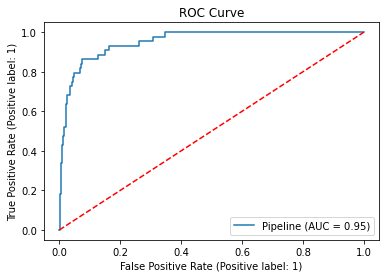

In [47]:
# ROC Curve
plot_roc_curve(pipe, X_test, y_test)
plt.title('ROC Curve')
plt.plot([0, 1], [0, 1], 'r--')
plt.show()

## Learning Curve

In [57]:
scaler = Pipeline([
    ('robustscaler', RobustScaler())])

preprocessor = ColumnTransformer([
    ('scaler', scaler, df_model.drop('Bankrupt?', axis=1).columns)
    ],
    remainder='passthrough')

pipe = Pipeline([
    ('preprocessing', preprocessor),
    ('smote', SMOTE(sampling_strategy='minority', random_state=10,k_neighbors=1)),
    ('model', RandomForestClassifier(n_estimators=200,class_weight='balanced_subsample',max_depth=10))])

In [58]:
y = df_model['Bankrupt?']
X = df_model.drop('Bankrupt?', axis=1)

In [60]:
train_sizes, train_scores, test_scores = learning_curve(estimator = pipe,
                                                        X = X,
                                                        y = y,
                                                        train_sizes = [50,100,200,300,400,600,800,1500,2000,3000,4000,4500,4700],
                                                        cv = 5,
                                                        scoring='recall',
                                                        shuffle = True,
                                                        random_state=0,
                                                        error_score=np.nan)

C:\Users\mattb\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:610: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\mattb\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\mattb\anaconda3\lib\site-packages\imblearn\pipeline.py", line 262, in fit
    Xt, yt = self._fit(X, y, **fit_params_steps)
  File "C:\Users\mattb\anaconda3\lib\site-packages\imblearn\pipeline.py", line 220, in _fit
    X, y, fitted_transformer = fit_resample_one_cached(
  File "C:\Users\mattb\anaconda3\lib\site-packages\joblib\memory.py", line 352, in __call__
    return self.func(*args, **kwargs)
  File "C:\Users\mattb\anaconda3\lib\site-packages\imblearn\pipeline.py", line 388, in _fit_resample_one
    X_res, y_res = sampler.fit_resample(X, y, **fit_par

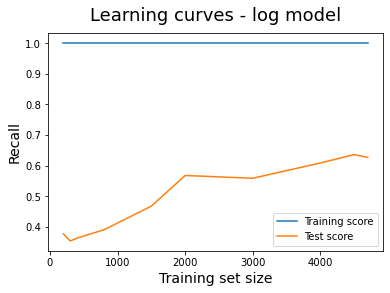

In [61]:
train_scores_mean = np.mean(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)
plt.plot(train_sizes, train_scores_mean, label = 'Training score')
plt.plot(train_sizes, test_scores_mean, label = 'Test score')
plt.ylabel('Recall', fontsize = 14)
plt.xlabel('Training set size', fontsize = 14)
plt.title('Learning curves - log model', fontsize = 18, y = 1.03)
plt.legend()
plt.show()

# Pickle et nouvelle prédiction

In [63]:
# pipe.fit(X_train, y_train)
                               
# with open("model_bankrupt.pkl", "wb") as file:
#     pickle.dump(pipe, file)

Ramplacer les point d'interrogations par le chemin du dataset

In [ ]:
df_NewData = pd.read_csv('?????.csv')

In [ ]:
df_corr = df_newData.corr()['Bankrupt?'] 
golden_features_list = df.columns[abs(df_corr) > 0.15]
df_model = df[golden_features_list]

In [ ]:
y = df_model['Bankrupt?']
X = df_model.drop('Bankrupt?', axis=1)

In [ ]:
sf = StratifiedKFold(n_splits=5, shuffle=True, random_state=1)
#The folds are made by preserving the percentage of samples for each class.
for train_index, test_index in sf.split(X,y):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]

Import du pickle

In [ ]:
model = pickle.load(open("model_bankrupt.pkl","rb"))


y_pred = model.predict(X_test)
print(classification_report(y_test, y_pred))
print(confusion_matrix(y_test, y_pred))